In [1]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Comparison on multiple datasets

In [2]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import EntropyEvaluator
from pyuid3.uncertain_entropy_evaluator import UncertainEntropyEvaluator
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [3]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [4]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [5]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [6]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    y_test_appended = np.concatenate([y_test,[1]])
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [7]:
shap.initjs()

In [8]:
class UncertainGiniEvaluator(EntropyEvaluator):
    def calculate_entropy(self, data: Data) -> float:
        class_att = data.get_attributes()[-1]
        probs = data.calculate_statistics(class_att)
        gini = 1-sum(map(lambda v: v.get_confidence()**2  if v.get_confidence()!=0 else 0, probs.get_statistics()))
        return gini
    
    def calculate_raw_entropy(self, labels: list,base: int = 2) -> float:
        value,counts = np.unique(labels, return_counts=True)
        gini = 1-sum([(c/len(labels))**2 for c in counts])
        return gini
    

In [9]:
class UncertainSqrtGiniEvaluator(EntropyEvaluator):
    def calculate_entropy(self, data: Data) -> float:
        class_att = data.get_attributes()[-1]
        probs = data.calculate_statistics(class_att)
        gini = 1-sum(map(lambda v: v.get_confidence()**2  if v.get_confidence()!=0 else 0, probs.get_statistics()))
        return np.sqrt(gini)
    
    def calculate_raw_entropy(self, labels: list,base: int = 2) -> float:
        value,counts = np.unique(labels, return_counts=True)
        gini = 1-sum([(c/len(labels))**2 for c in counts])
        return np.sqrt(gini)
        

In [10]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

Accuracy  model: 0.888 for data_house_16H
----------- Model certainty for instance: 0.65 ---------------
Neighbourhood size: 50
Average distace of neighbourhood: 3.376379978725635.


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


Traiun sample size: 0.232


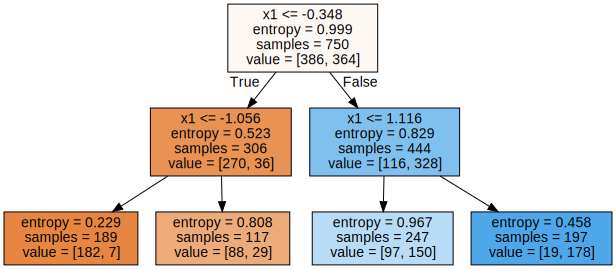

Fidelity  dectree: 0.7
Accuracy  dectree: 0.72


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.232 samples from train set wiuth class balance: 0.5


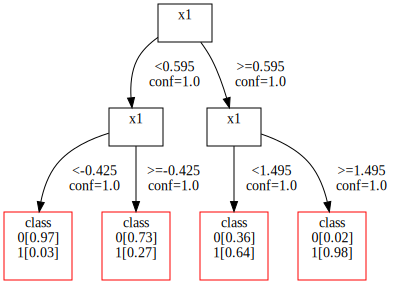

IF x1  >= 0.595 AND x1  < 1.495 THEN class = 1 # 0.6382978723404256



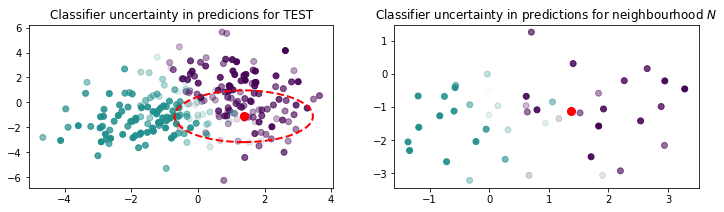

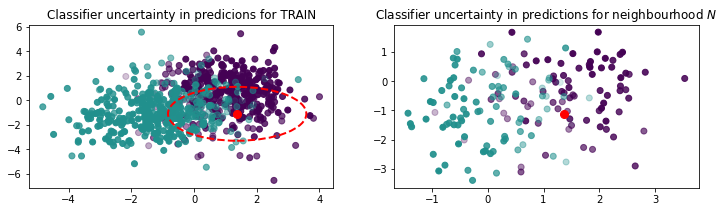

Fidelity  no proba: 0.9
Accuracy  no proba: 0.84


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.232 samples from train set wiuth class balance: 0.5


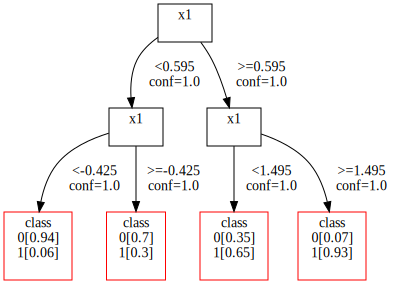

IF x1  >= 0.595 AND x1  < 1.495 THEN class = 1 # 0.6489361702127661



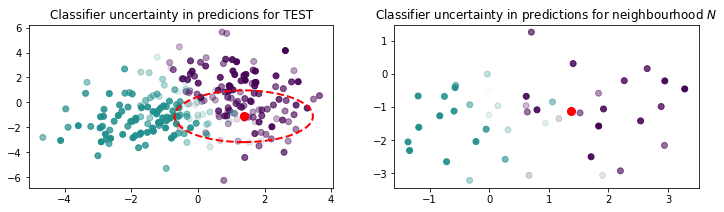

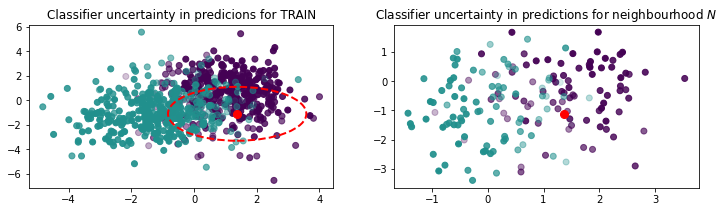

Fidelity  with proba: 0.9
Accuracy  with proba: 0.84


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.232 samples from train set wiuth class balance: 0.5


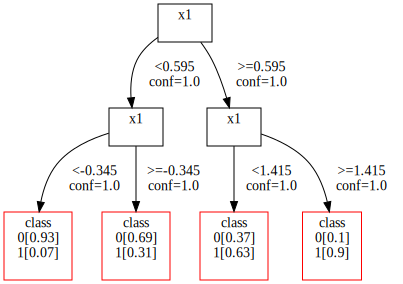

IF x1  >= 0.595 AND x1  < 1.415 THEN class = 1 # 0.6253846153846155



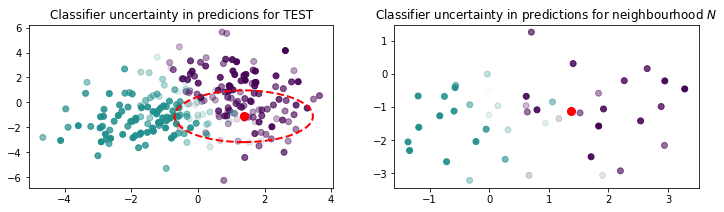

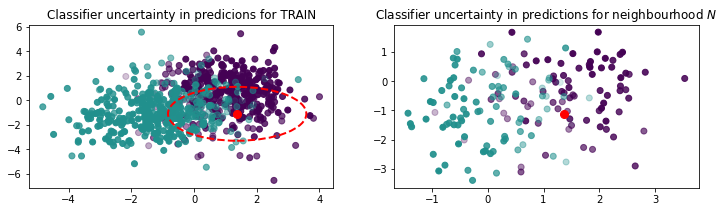

Fidelity  with shap: 0.9
Accuracy  with shap: 0.84
----------- Model certainty for instance: 0.51 ---------------
Neighbourhood size: 50
Average distace of neighbourhood: 3.542656638061451.


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


Traiun sample size: 0.23866666666666667


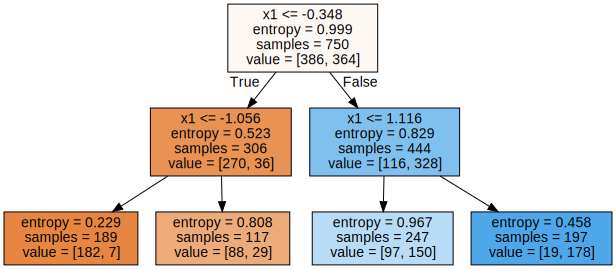

Fidelity  dectree: 0.82
Accuracy  dectree: 0.82


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.23866666666666667 samples from train set wiuth class balance: 0.40782122905027934


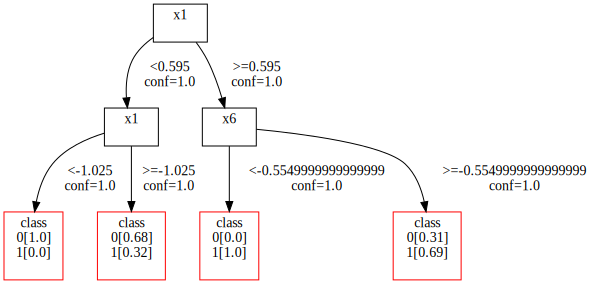

IF x1  < 0.595 AND x1  >= -1.025 THEN class = 0 # 0.6836734693877551



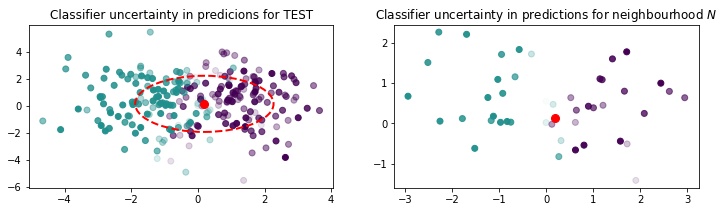

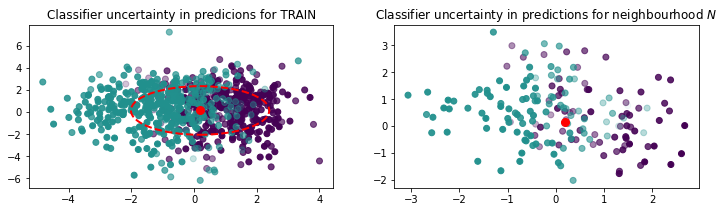

Fidelity  no proba: 0.92
Accuracy  no proba: 0.84


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.23866666666666667 samples from train set wiuth class balance: 0.40782122905027934


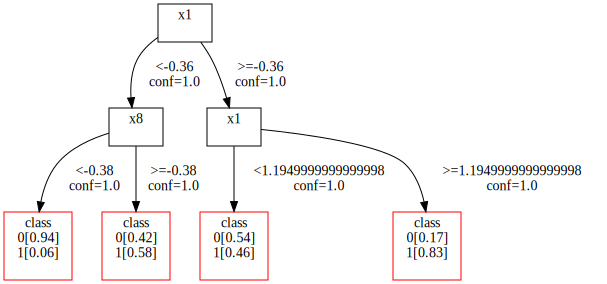

IF x1  >= -0.36 AND x1  < 1.1949999999999998 THEN class = 0 # 0.5444000000000002



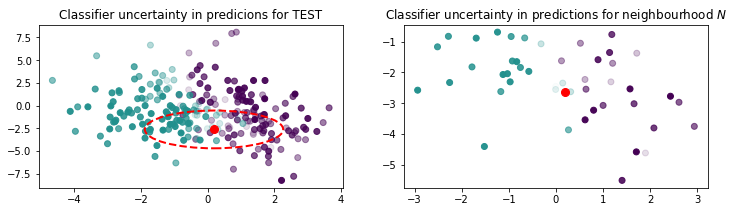

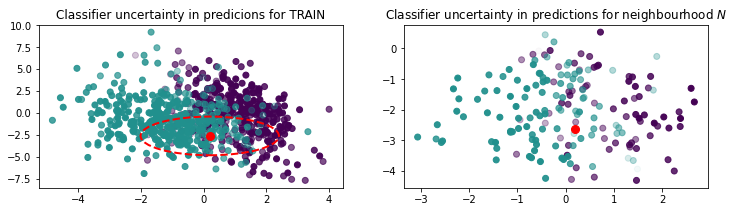

Fidelity  with proba: 0.74
Accuracy  with proba: 0.74


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.23866666666666667 samples from train set wiuth class balance: 0.40782122905027934


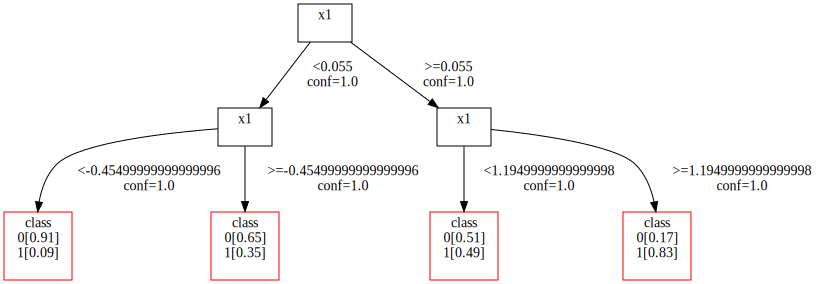

IF x1  >= 0.055 AND x1  < 1.1949999999999998 THEN class = 0 # 0.5103846153846153



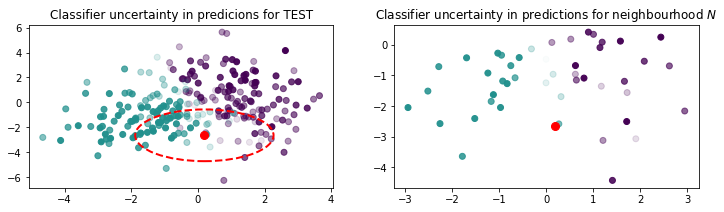

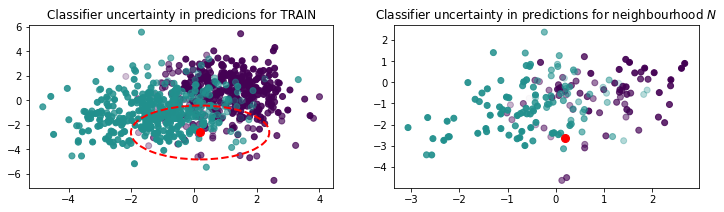

Fidelity  with shap: 0.74
Accuracy  with shap: 0.74
----------- Model certainty for instance: 0.97 ---------------
Neighbourhood size: 50
Average distace of neighbourhood: 2.908483668962508.


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


Traiun sample size: 0.24266666666666667


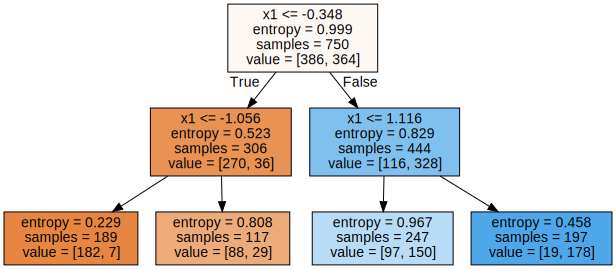

Fidelity  dectree: 0.82
Accuracy  dectree: 0.8


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.24266666666666667 samples from train set wiuth class balance: 0.41208791208791207


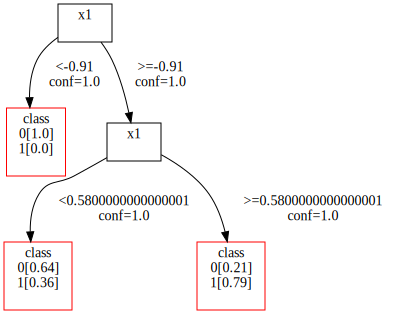

IF x1  >= -0.91 AND x1  < 0.5800000000000001 THEN class = 0 # 0.6436781609195402



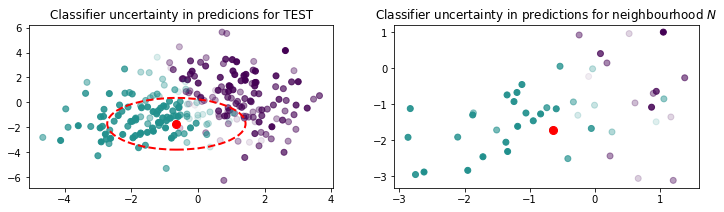

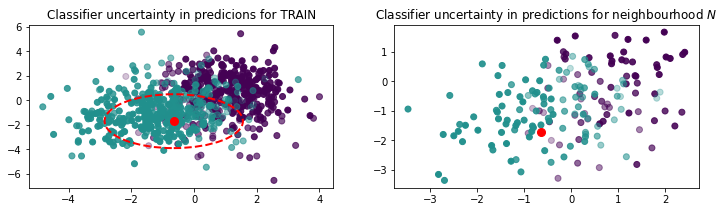

Fidelity  no proba: 0.82
Accuracy  no proba: 0.84


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.24266666666666667 samples from train set wiuth class balance: 0.41208791208791207


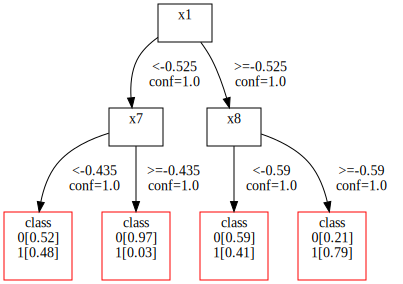

IF x1  < -0.525 AND x7  >= -0.435 THEN class = 0 # 0.9662962962962961



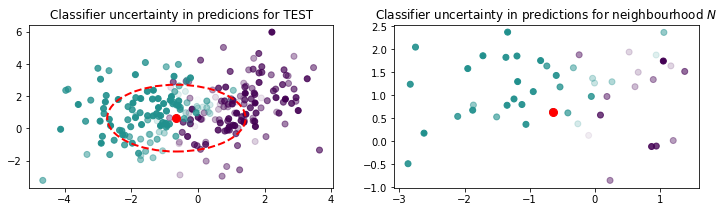

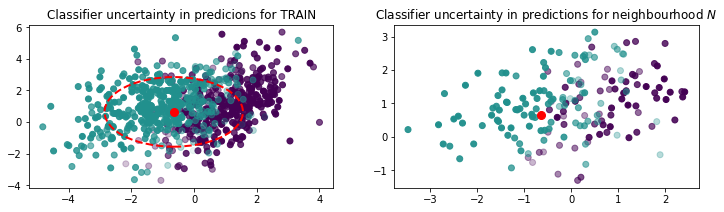

Fidelity  with proba: 0.8
Accuracy  with proba: 0.78


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.24266666666666667 samples from train set wiuth class balance: 0.41208791208791207


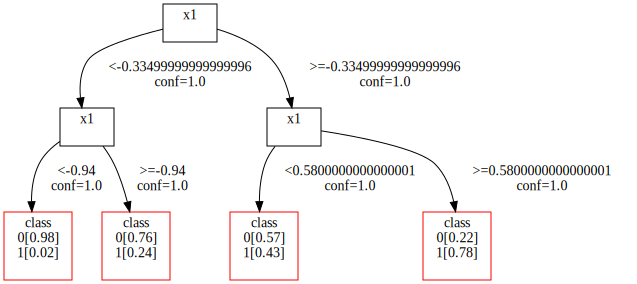

IF x1  < -0.33499999999999996 AND x1  >= -0.94 THEN class = 0 # 0.7642424242424243



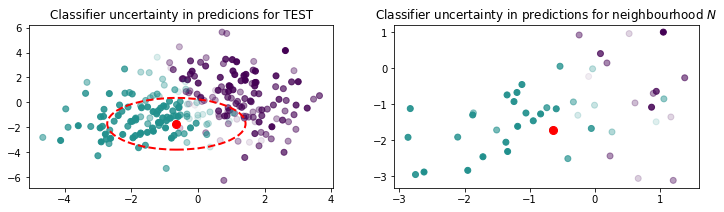

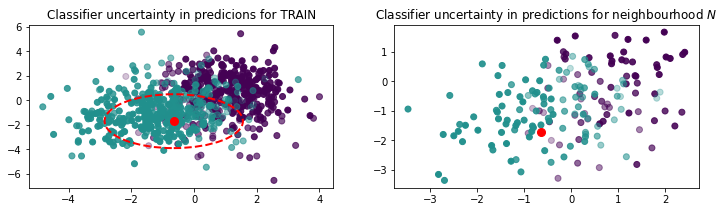

Fidelity  with shap: 0.82
Accuracy  with shap: 0.84
----------- Model certainty for instance: 0.54 ---------------
Neighbourhood size: 50
Average distace of neighbourhood: 3.1960056830822445.


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


Traiun sample size: 0.24133333333333334


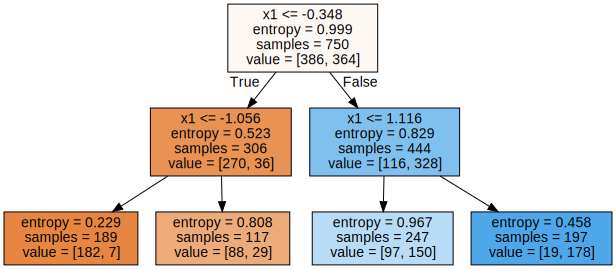

Fidelity  dectree: 0.86
Accuracy  dectree: 0.86


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.24133333333333334 samples from train set wiuth class balance: 0.4861878453038674


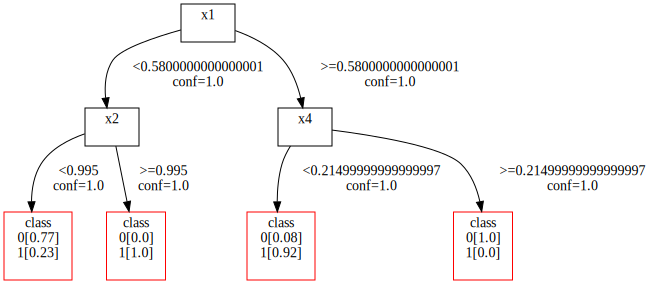

IF x1  < 0.5800000000000001 AND x2  < 0.995 THEN class = 0 # 0.7727272727272727



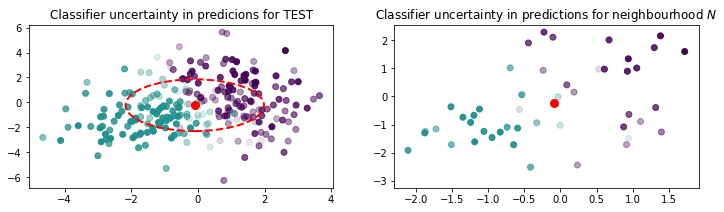

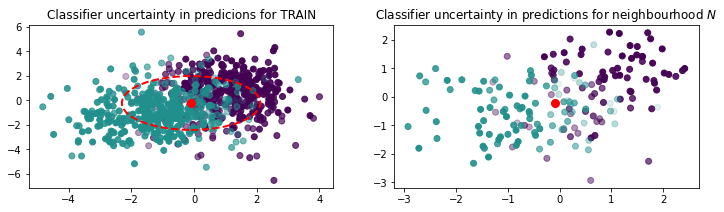

Fidelity  no proba: 0.78
Accuracy  no proba: 0.82


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.24133333333333334 samples from train set wiuth class balance: 0.4861878453038674


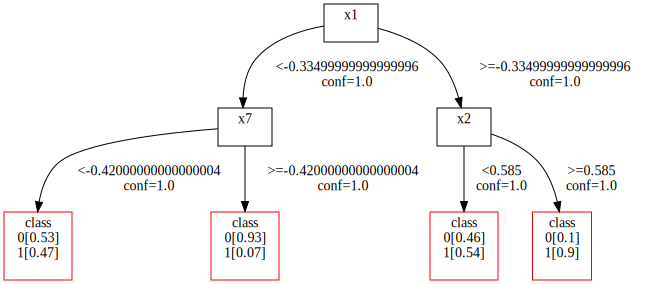

IF x1  >= -0.33499999999999996 AND x2  < 0.585 THEN class = 1 # 0.5393939393939394



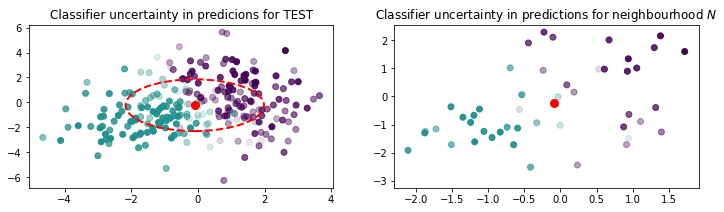

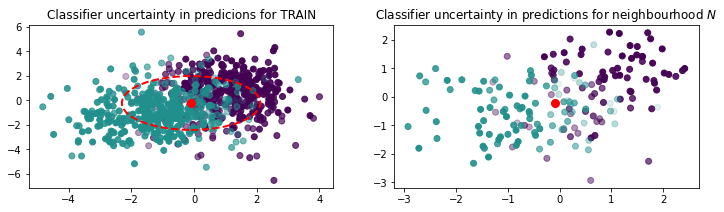

Fidelity  with proba: 0.86
Accuracy  with proba: 0.86


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.24133333333333334 samples from train set wiuth class balance: 0.4861878453038674


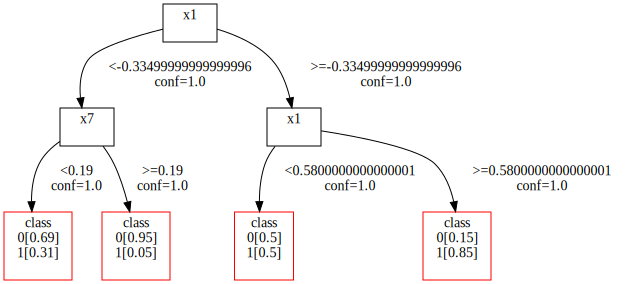

IF x1  >= -0.33499999999999996 AND x1  < 0.5800000000000001 THEN class = 1 # 0.5009433962264153



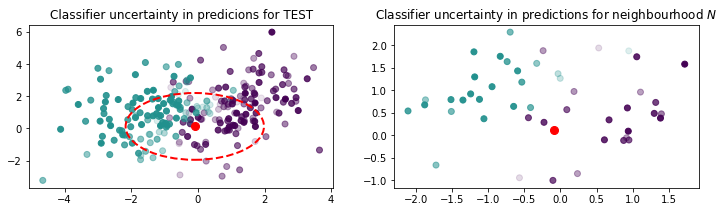

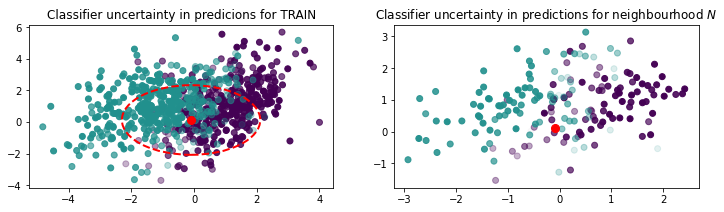

Fidelity  with shap: 0.86
Accuracy  with shap: 0.86
----------- Model certainty for instance: 0.95 ---------------
Neighbourhood size: 50
Average distace of neighbourhood: 4.156101141145176.


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


Traiun sample size: 0.268


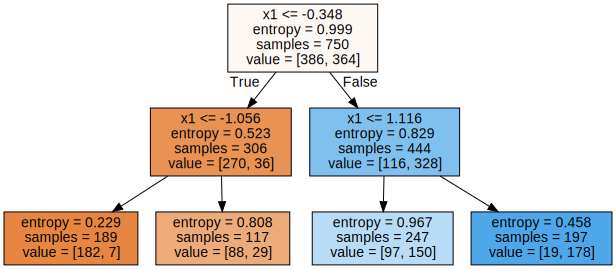

Fidelity  dectree: 0.8
Accuracy  dectree: 0.82


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but NearestNeighbors was fitted with feature names


In fact using: 0.268 samples from train set wiuth class balance: 0.38308457711442784


In [ ]:
nac_data  = []
fid_data = []
rs=42
fraction=0.2
directory = './data/numerical_only/balanced'
#directory = './data/num_and_cat/balanced'
up=True
depth = 2
SAMPLE_SIZE=10
show=True
ismpl=True
synthetic = True
density_sampling=True
radius_sampling=False
oversampling=False
uncertain_entropy_evaluator=UncertainEntropyEvaluator()
representative=LUX.REPRESENTATIVE_CENTROID


for num_and_cat in  os.listdir(directory):
    #(data, y, categorical_indicator) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    (data, y) = pickle.load(open(f'{directory}/{num_and_cat}','rb'))
    features = [f'f_{i}' for i in range(0,data.shape[1])]
    target = 'class'
    df = pd.DataFrame(data,columns=features,dtype=float)
    sc = StandardScaler()
    df.loc[:]=sc.fit_transform(df)#normalize(df, axis=0)#sc.fit_transform(df)
    df[target] = y
    
    if synthetic: 
        #,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.35, random_state=0)#factor=0.5
        X,y= sklearn.datasets.make_classification(n_samples=1000, n_features=8, 
                                              n_informative=6, n_redundant=2, n_repeated=0, n_clusters_per_class=3,
                                              n_classes=2)
        features = [f'x{i}' for i in range(1,X.shape[1]+1)]
        df = pd.DataFrame(X, columns=features)
        df[target] = y
    
    if len(df) > 5000:
        fraction = 1000.0/len(df)
    else:
        fraction = 0.2
        
    
    
    ## train xgboost, 
    train, test = train_test_split(df, random_state=rs)
    clf = RandomForestClassifier(random_state=rs,n_jobs=-1)
    #clf = svm.SVC(probability=True,random_state=rs)
    clf.fit(train[features],train[target])
    model_score = accuracy_score(clf.predict(test[features]),test[target])
    print(f'Accuracy  model: {model_score} for {num_and_cat}')
     #claculate shap, 
    # explainer = shap.TreeExplainer(clf)#, train[features])
    # #explainer = shap.KernelExplainer(clf.predict_proba, train[features])

    # shap_values = explainer.shap_values(train_orig[features],check_additivity=True)
    
    ##try sampling only around decision boundary?
    
    
    for explain_instance in test[features].sample(SAMPLE_SIZE,random_state=rs).values:
        explain_instance=np.array(explain_instance).reshape(1,-1)
        #explain_instance = test[features].sample(1).values#.astype('f8')    
        
        instance_certainty_clf = np.max(clf.predict_proba(explain_instance))
        print(f'----------- Model certainty for instance: {np.max(clf.predict_proba(explain_instance))} ---------------')
    
        # distances = sklearn.metrics.pairwise_distances(test[features], explain_instance)
        # pd.DataFrame(distances).hist()
        # plt.show()
        # _,borders = np.histogram(distances)
        # idxs,_ = np.where(distances<=borders[2])
        # dfneigh = test.iloc[idxs]
        # print(f'Neighbourhood size: {len(dfneigh)}')
        
        n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
        nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
        nn.fit(test[features])
        dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
        print(f'Neighbourhood size: {len(ids_c.ravel())}')
        print(f'Average distace of neighbourhood: {np.mean(dst)}.')
        dfneigh= test.iloc[ids_c.ravel()]
        
        
        
        ##############for testing dectree on the bbox sample################
        lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  
                  node_size_limit = 2, grow_confidence_threshold = 0)
        X_train_sample, _ = lux.create_sample_bb(train[features], train[target],[explain_instance],
                                                  X_importances = None, exclude_neighbourhood=False, class_names=[0,1],
                                                  use_parity=up, inverse_sampling=ismpl, radius_sampling=radius_sampling,oversampling=oversampling,
                                                 representative=representative,density_sampling=density_sampling)
        print(f'Traiun sample size: {len(X_train_sample)/len(train)}')
        ###################################################################
        #shap on this sample
        #append pint as a first element and plot force plot
        # X_shap = pd.concat((pd.DataFrame(explain_instance,columns=features),X_train_sample[features]))
        # explainer = shap.TreeExplainer(clf, X_shap)
        # shap_values = explainer.shap_values(X_shap,check_additivity=True)
        # shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[1][0,:],feature_names = features )

        data = Data.parse_dataframe(dfneigh[features+[target]])
        clf_dtree = DecisionTreeClassifier(random_state=rs,max_depth=depth,criterion='entropy')
        clf_dtree.fit(train[features],clf.predict(train[features]))

        if show:
            graph = Source(tree.export_graphviz(clf_dtree, out_file=None
               , feature_names=features, 
                                                #class_names=['0', '1'] ,
                filled = True,max_depth=depth))
            display(SVG(graph.pipe(format='svg')))

        dectree_score =  accuracy_score(clf_dtree.predict(dfneigh[features]),clf.predict(dfneigh[features]))
        print(f'Fidelity  dectree: {dectree_score}')
        dectree_score_acc =  accuracy_score(clf_dtree.predict(dfneigh[features]),dfneigh[target])
        print(f'Accuracy  dectree: {dectree_score_acc}')
       

        #explain xgboost without proba, 
        lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0)
        lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up,oversampling=oversampling,representative=representative,
                radius_sampling=radius_sampling, inverse_sampling=ismpl ,density_sampling=density_sampling, n_jobs=-1,
               uncertain_entropy_evaluator=uncertain_entropy_evaluator)

        #calculate decision tree score over this dataset
        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
            
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
        if synthetic and X_train_sample.shape[1] == 2:
            decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)
        

        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_pure = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  no proba: {ac_score_pure}')
        ac_score_pure_acc =  accuracy_score(predictions,dfneigh[target])
        print(f'Accuracy  no proba: {ac_score_pure_acc}')

        #with proba, 
        lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        lux.fit(train[features], train[target], instance_to_explain=explain_instance,use_parity=up, 
                uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,representative=representative,
                radius_sampling=radius_sampling,inverse_sampling= ismpl,density_sampling=density_sampling, n_jobs=-1)
        
        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
            
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
       # decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)


        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_proba = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  with proba: {ac_score_proba}')
        ac_score_proba_acc =  accuracy_score(predictions,dfneigh[target])
        print(f'Accuracy  with proba: {ac_score_proba_acc}')

        
        lux = LUX(classifier = clf,predict_proba = clf.predict_proba, neighborhood_size=fraction,max_depth=depth,  node_size_limit = 2, grow_confidence_threshold = 0 )
        lux.fit(train[features], train[target], 
                X_importances = None,uncertain_entropy_evaluator=uncertain_entropy_evaluator,oversampling=oversampling,
                instance_to_explain=explain_instance,discount_importance=False,radius_sampling=radius_sampling,representative=representative,
                use_parity=up, inverse_sampling=ismpl,density_sampling=density_sampling, n_jobs=-1 )

        if show:
            lux.uid3.tree.save_dot('tree.dot')
            gvz=graphviz.Source.from_file('tree.dot')
            display(gvz)
        f1,f2=get_plot_features(lux,explain_instance,all_features = features)
        plot_neighbourhood(clf,test[features],test[target], dfneigh[features], explain_instance.ravel(),f1=f1,f2=f2)
        plot_neighbourhood(clf,train[features],train[target], X_train_sample, explain_instance.ravel(),f1=f1,f2=f2, train_test_label='TRAIN')
        #decision_boundary(clf_dtree,lux, explain_instance.ravel(), X_train_sample,clf.predict(X_train_sample),f1=f1,f2=f2)

        predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
        ac_score_shap = accuracy_score(predictions, clf.predict(dfneigh[features]))
        print(f'Fidelity  with shap: {ac_score_shap}')
        ac_score_shap_acc = accuracy_score(predictions, dfneigh[target])
        print(f'Accuracy  with shap: {ac_score_shap_acc}')
    

        fid_data.append([num_and_cat,num_and_cat,instance_certainty_clf,ac_score_pure,ac_score_proba,ac_score_shap, model_score, dectree_score])
        nac_data.append([num_and_cat,num_and_cat,instance_certainty_clf,ac_score_pure_acc,ac_score_proba_acc,ac_score_shap_acc, model_score, dectree_score_acc])
    ## save results        
    

In [ ]:
results = pd.DataFrame(nac_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_pure','ac_score_proba','ac_score_shap', 'model_score', 'dectree_score'])
results.groupby('dataset').mean().plot(style='.-',figsize=(12,9))
                       

In [ ]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_pure','ac_score_proba','ac_score_shap', 'model_score', 'dectree_score'])
results_fid.groupby('dataset').mean().plot(style='.-',figsize=(12,9))
                       

In [ ]:
results_fid.mean()

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_fid,notch=True,ax=ax)

<AxesSubplot:>

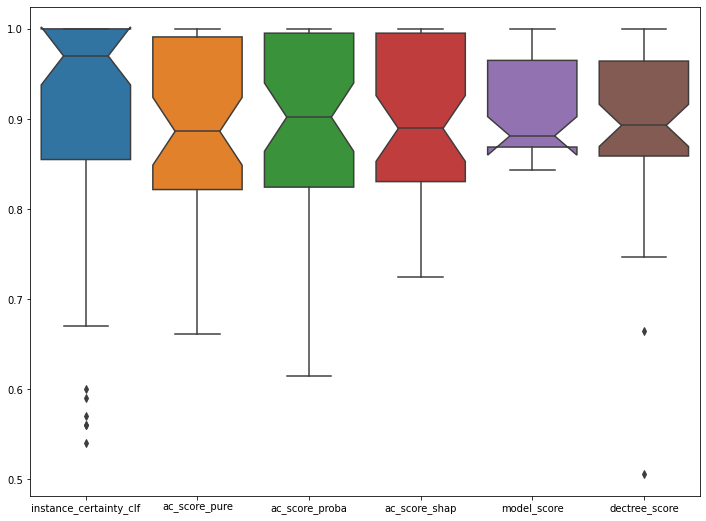

In [17]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_fid,notch=True,ax=ax)

<AxesSubplot:>

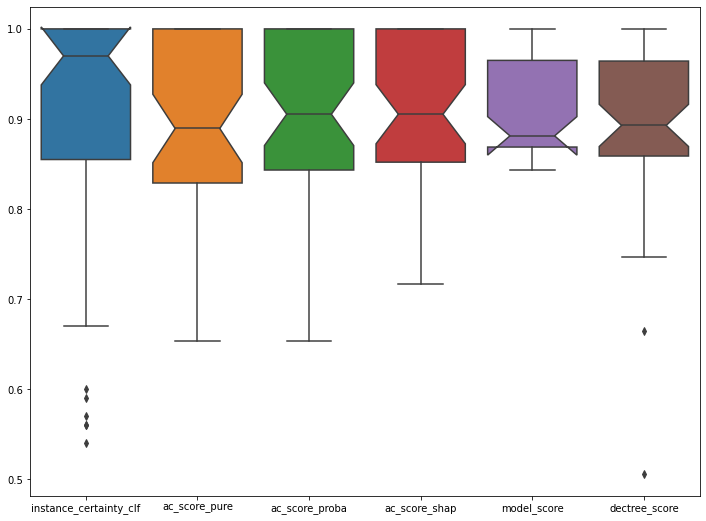

In [43]:
fig, ax = plt.subplots(figsize=(12,9))
sns.boxplot(data=results_fid,notch=True,ax=ax)

<AxesSubplot:>

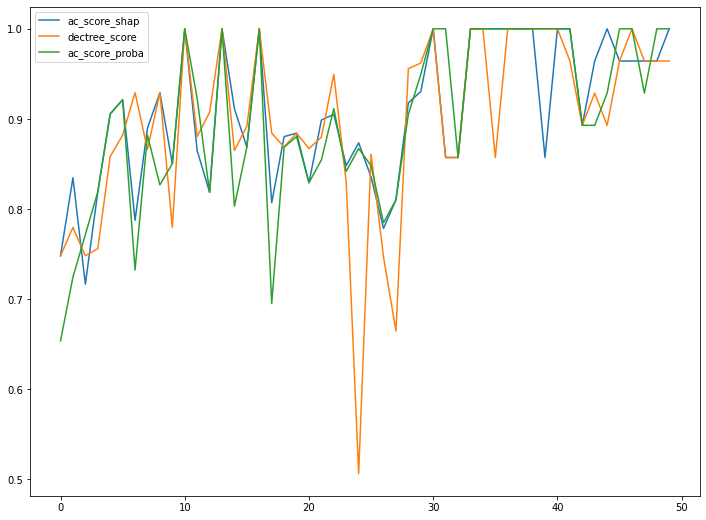

In [44]:
results_fid = pd.DataFrame(fid_data,columns=['dataset','num_and_cat','instance_certainty_clf','ac_score_pure','ac_score_proba','ac_score_shap', 'model_score', 'dectree_score'])
results_fid[['ac_score_shap', 'dectree_score','ac_score_proba']].plot(figsize=(12,9))

In [ ]:
results.to_csv('results_background_subset_set_real_f02n02.csv',index=False)

In [ ]:
n_neighbors=int(len(test)*0.2) # change to 0.5? or radius?
nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
nn.fit(train[features].reset_index(drop=True))
dst,ids_c = nn.kneighbors(np.array(explain_instance).reshape(1,-1))
print(f'Neighbourhood size: {len(ids_c.ravel())}')
print(f'Average distace of neighbourhood: {np.mean(dst)}.')
dfneigh= train.iloc[ids_c.ravel()]